# WECC Load Correlations

In [1]:
# Start by importing the packages we need:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm


## Set the Directory Structure

In [2]:
# Identify the data input and output directories:
load_data_input_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs/tell_data/outputs/tell_output/'
metadata_input_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Analysis/'
image_output_dir =  '/Users/burl878/Documents/Travel/2023_AGU_Fall_Meeting/Poster/Figures/'


## Aggregate the Load Time Series


In [3]:
# Define a function to aggregate the load time series across BAs:
def process_load_time_series(load_data_input_dir: str, metadata_input_dir: str, scenario: str, start_year: int, end_year: int):
    # Read in the BA-to-interconnection mapping file:
    ba_mapping = pd.read_csv((metadata_input_dir + 'BA_to_Interconnection_Mapping.csv'))

    # Loop over the years and aggregate the load output file in each year:
    for year in range(start_year,end_year,1):
    
        # Read in the TELL BA output file:
        tell_df = pd.read_csv((load_data_input_dir + scenario + '/' + str(year) + '/' + 'TELL_Balancing_Authority_Hourly_Load_Data_' + str(year) + '_Scaled_' + str(year) + '.csv'))
        #tell_df = pd.read_csv((load_data_input_dir + scenario + '/2019/' + 'TELL_Balancing_Authority_Hourly_Load_Data_' + str(year) + '_Scaled_2019.csv'))
        
        # Merge in the interconnection mapping using common BA codes:
        tell_df = pd.merge(tell_df, ba_mapping, on='BA_Code')
        
        # Subset to just the BAs in the WECC:
        tell_df = tell_df.loc[tell_df['Interconnection'] == 'WECC']
        
        # Rename the a few columns to make them more readable:
        tell_df.rename(columns={'BA_Code': 'BA', 'Scaled_TELL_BA_Load_MWh': 'Load_MWh'}, inplace=True)
    
        # Only keep the columns we need:
        tell_df = tell_df[['BA','Time_UTC','Load_MWh']]
        
        # Aggregate the output into a new dataframe:
        if year == start_year:
           output_df = tell_df
        else:
           output_df = pd.concat([output_df , tell_df])
    
    return output_df


## Make the Correlation Plot


In [8]:
# Define a function to plot the seasonal correlation in loads across BAs:
def plot_load_correlation(load_data_input_dir: str, metadata_input_dir: str, scenario: str, start_year: int, end_year: int, months, title_str: str,
                          image_output_dir: str, image_resolution: int, save_images=False):
    
    # Process the load time series:
    load_df = process_load_time_series(load_data_input_dir = load_data_input_dir, 
                                       metadata_input_dir = metadata_input_dir, 
                                       scenario = scenario, 
                                       start_year = start_year, 
                                       end_year = end_year)
    
    # Convert the timestamp into a datetime variable:
    load_df['Time_UTC'] = pd.to_datetime(load_df['Time_UTC'])
   
    # Use datetime string to get the year, month, day, and hour:
    load_df['Month'] = load_df['Time_UTC'].dt.strftime('%m').astype(int)
    
    # Subset to just the months being analyzed:
    load_df = load_df.loc[load_df['Month'].isin(months)]
    
    # Pivot the dataframe:
    load_df_pivoted = load_df.pivot(index = 'Time_UTC', columns = 'BA', values = 'Load_MWh')

    # Calculate the correlation matrix of the dataframe:
    corr_df = load_df_pivoted.corr(method = 'spearman')
    
    # Fill diagonal and upper half with NaNs:
    mask = np.zeros_like(corr_df, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    corr_df[mask] = np.nan

    # Specify the colormap:
    colors = cm.get_cmap('viridis_r', 12)
    
    # Make the correlation plot:
    f = plt.figure(figsize=(25, 10))
    plt.rcParams['font.size'] = 18
    plt.matshow(corr_df, fignum=f.number, cmap=colors, vmin=0.7, vmax=1)
    # cb = plt.colorbar().ax.tick_params(labelsize=18)
    plt.title((title_str), fontsize=24);
    plt.xticks(range(len(corr_df.columns)), corr_df.columns, rotation='vertical')
    plt.yticks(range(len(corr_df.columns)), corr_df.columns)
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
        filename = ('Correlation_' + title_str + '.png').replace(" ", "_").replace("-", "_").replace(",", "")
        plt.savefig(os.path.join(image_output_dir, filename), dpi=image_resolution, bbox_inches='tight')
        
    # Print the average correlation across all BAs:
    print(('Average Correlation, ' + title_str + ' = ' + str(corr_df.reset_index(drop=True).stack().mean().round(2))))
    
    # Return the processed dataframe:
    return corr_df


Average Correlation, rcp45cooler_ssp3, Jun-Jul-Aug, 2020-2059 = 0.84


BA,AVA,AZPS,BANC,BPAT,CHPD,CISO,DOPD,EPE,GCPD,IID,...,PSCO,PSEI,SCL,SRP,TEPC,TIDC,TPWR,WACM,WALC,WAUW
BA,,,,,,,,,,,,,,,,,,,,,
AVA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AZPS,0.834248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BANC,0.819505,0.890521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BPAT,0.952495,0.837091,0.857871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHPD,0.950139,0.793921,0.794453,0.949919,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CISO,0.811530,0.892958,0.950527,0.862705,0.797241,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DOPD,0.931188,0.792407,0.797657,0.899849,0.921540,0.816192,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EPE,0.816420,0.835759,0.777816,0.829211,0.786178,0.765393,0.693207,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCPD,0.890010,0.766631,0.783340,0.881376,0.883256,0.806277,0.928223,0.727650,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


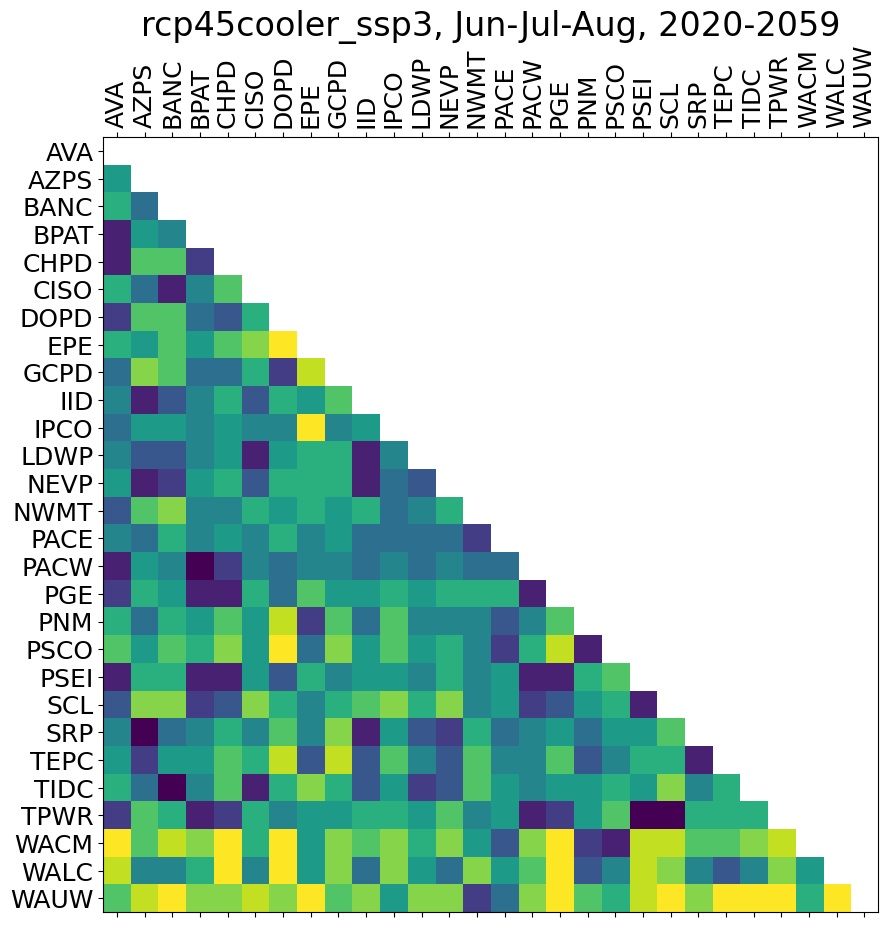

In [10]:
corr_df = plot_load_correlation(load_data_input_dir =  load_data_input_dir, 
                                metadata_input_dir = metadata_input_dir, 
                                scenario = 'rcp45cooler_ssp3', 
                                start_year = 2020, 
                                end_year = 2060,
                                months = [6, 7, 8],
                                title_str = 'rcp45cooler_ssp3, Jun-Jul-Aug, 2020-2059',
                                image_output_dir = image_output_dir, 
                                image_resolution = 300, 
                                save_images = True)

corr_df
